#!/usr/bin/env python
# coding: utf-8
# # %pip install tensorflow matplotlib seaborn scikit-learn
# C:\Users\happy\Documents\ironhack\Week7\Project2-G2>pylint cleaned_cnn_script.py --disable=E1101,E0611,E0401

# -------------------------------------------------------------------
# Your code has been rated at 10.00/10 (previous run: 6.92/10, +3.08)
"""
Train and evaluate a CNN on CIFAR-10 using transfer learning with MobileNetV2.
Includes preprocessing, model training, evaluation, fine-tuning, and saving.
"""

In [1]:
# Import necessary libraries
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [4]:
# Set image size and batch size
IMG_SIZE = 160
BATCH_SIZE = 32

In [5]:
# Image preprocessing function
def preprocess(image, name):
    """
    Resize image to target size and normalize pixel values to [0, 1].
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, name

In [6]:
# Build TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = (
    train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

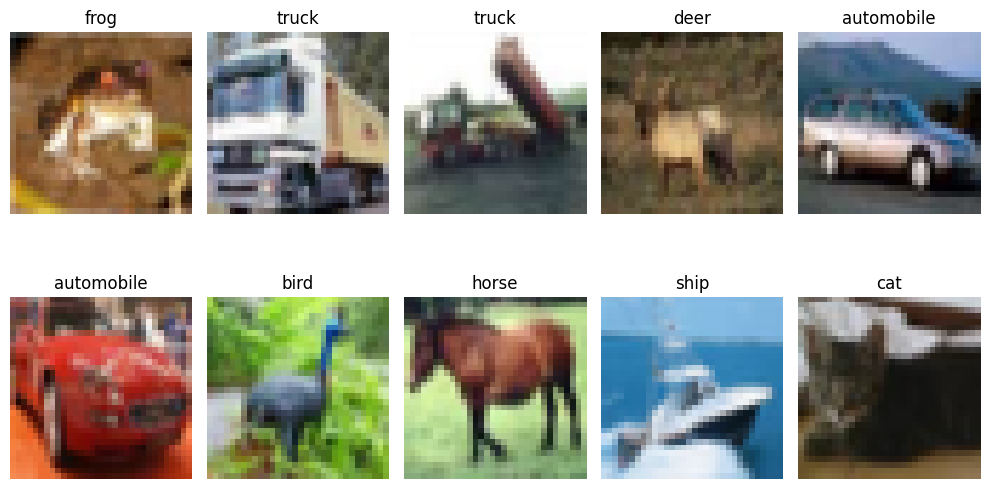

In [7]:
# Visualize sample images
plt.figure(figsize=(10, 6))
for i in range(10):
    img = x_train[i]
    label = class_names[y_train[i][0]]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# Load base MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze base layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(10, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)

In [10]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [11]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - accuracy: 0.6880 - loss: 0.9125 - val_accuracy: 0.8048 - val_loss: 0.5572
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.7990 - loss: 0.5884 - val_accuracy: 0.8205 - val_loss: 0.5144
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.8123 - loss: 0.5456 - val_accuracy: 0.8124 - val_loss: 0.5355
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8272 - loss: 0.5016 - val_accuracy: 0.8227 - val_loss: 0.5158
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8339 - loss: 0.4800 - val_accuracy: 0.8286 - val_loss: 0.5037
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8448 - loss: 0.4484 - val_accuracy: 0.8308 - val_loss: 0.5067
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8500 - loss: 0.4312 - val_accuracy: 0.8298 - val_loss: 0.5126
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.8520 -

In [13]:
# Evaluate the model on the test set
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8301 - loss: 0.5071
Test Accuracy: 0.8286


In [14]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step


In [15]:
# Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.84      0.84      0.84      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.76      0.79      0.78      1000
         cat       0.69      0.72      0.71      1000
        deer       0.76      0.81      0.78      1000
         dog       0.79      0.78      0.78      1000
        frog       0.89      0.83      0.86      1000
       horse       0.86      0.85      0.86      1000
        ship       0.90      0.86      0.88      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



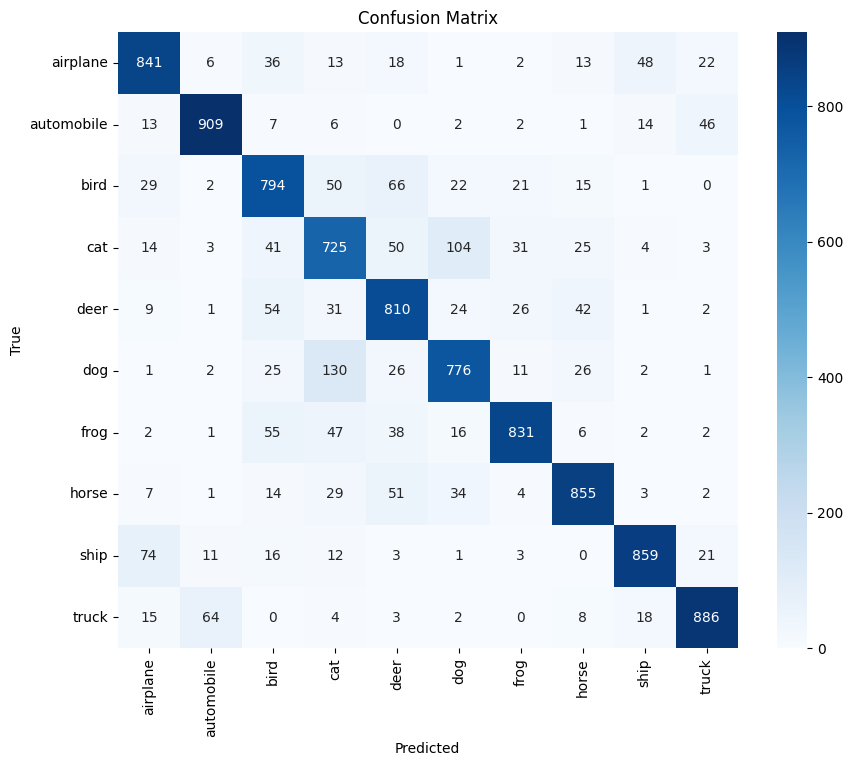

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [17]:
#Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Save the model
model.save('cifar10_base_model.keras')

In [25]:
#Verify saving

drive_path = '/content/'
for item in os.listdir(drive_path):
    print(item)

.config
drive
cifar10_base_model.keras
sample_data


In [26]:
# Unfreeze from layer 100 onwards (out of ~154)
UNFREEZE_FROM = 100

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers before `UNFREEZE_FROM`
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= UNFREEZE_FROM


In [27]:
# Re-compile model for fine-tuning with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [28]:
# Train again with fine-tuning
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 94s 44ms/step - accuracy: 0.7225 - loss: 0.9275 - val_accuracy: 0.8499 - val_loss: 0.4596
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8336 - loss: 0.4967 - val_accuracy: 0.8652 - val_loss: 0.4105
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.8635 - loss: 0.4035 - val_accuracy: 0.8763 - val_loss: 0.3834
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.8856 - loss: 0.3390 - val_accuracy: 0.8829 - val_loss: 0.3617
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8976 - loss: 0.2966 - val_accuracy: 0.8882 - val_loss: 0.3504
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.9115 - loss: 0.2587 - val_accuracy: 0.8922 - val_loss: 0.3441
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9219 - loss: 0.2207 - val_accuracy: 0.8949 - val_loss: 0.3390
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9322 -

In [29]:
model.save('cifar10_transfer_model.keras')

In [30]:
#Verify saving
drive_path = '/content/'
for item in os.listdir(drive_path):
    print(item)

.config
drive
cifar10_base_model.keras
cifar10_transfer_model.keras
sample_data
